In [1]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from collections import Counter
from datasets import load_dataset, load_from_disk
import numpy as np

# WikiTextデータセットのロード
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

# 単語頻度のカウント
word_counts = Counter()
for sentence in dataset['text']:
    words = sentence.split()
    word_counts.update(words)

# 単語を頻度順にソート
sorted_word_counts = sorted(word_counts.values(), reverse=True)


In [2]:
dataset_alpha20 = load_from_disk("wikitext-alpha-2.0")
word_counts = Counter()
for sentence in dataset_alpha20['text']:
    words = sentence.split()
    word_counts.update(words)

sorted_word_counts_alpha20 = sorted(word_counts.values(), reverse=True)


Slope coefficient for WikiText: -0.9527358132942542
Slope coefficient for 単語刈り込みWikiText: -2.142985991606697


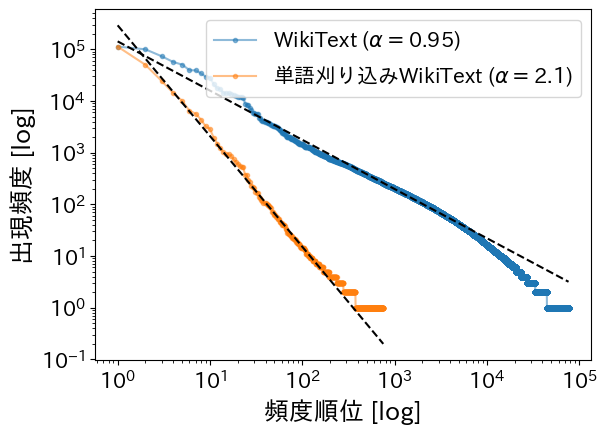

In [13]:
def plot_word_counts(word_counts, ax, label="", bulk_ratio=None, start_point=1, show_slope=True):
    eigenvalues = word_counts
    indices = np.arange(1, len(eigenvalues) + 1)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]

    start_index = max(start_point, 1)  # start_pointが1未満の場合を防ぐためにmaxを使用
    bulk = int(len(eigenvalues) * bulk_ratio) if bulk_ratio is not None else len(eigenvalues)
    
    # 指定された範囲のインデックスと固有値に基づいて傾きを計算
    slope, intercept = np.polyfit(np.log(indices[start_index-1:bulk]), np.log(sorted_eigenvalues[start_index-1:bulk]), 1)

    # 元のプロット
    ax.loglog(indices, sorted_eigenvalues, '.-', label=fr"{label} ($\alpha=${-slope:.2})", alpha=0.5)
    if show_slope:
        # 補助線をグラフ全体に延長してプロット
        ax.loglog(indices, np.exp(intercept) * indices ** slope, 'k--')


    print(f"Slope coefficient for {label}: {slope}")


fig, ax = plt.subplots()
plot_word_counts(sorted_word_counts, ax, label="WikiText", start_point=1, bulk_ratio=0.08)
plot_word_counts(sorted_word_counts_alpha20, ax, label="単語刈り込みWikiText", start_point=0, bulk_ratio=0.1)

ax.set_xlabel("頻度順位 [log]", fontsize=18)
ax.set_ylabel("出現頻度 [log]", fontsize=18)
# tick font size
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(prop={'size': 15})
#plt.rcParams['figure.subplot.bottom'] = 0.15
plt.savefig("scaled_zipf_law.png",bbox_inches='tight', dpi=300)
plt.show()



In [10]:
from datasets import load_dataset, Dataset
from collections import Counter
import numpy as np

# alpha値を指定
alpha = 2.0  # 例: alpha = 1.2

# WikiTextデータセットのロード
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

# 単語頻度のカウント
word_counts = Counter()
for sentence in dataset['text']:
    words = sentence.split()
    word_counts.update(words)

# 単語を頻度順にソート
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# 単語に対するランクを辞書に変換
word_to_rank = {word: rank + 1 for rank, (word, _) in enumerate(sorted_word_counts)}

# ランクに応じて単語出現頻度を調整
adjusted_text = []

for sentence in dataset['text']:
    new_sentence = []
    words = sentence.split()
    for word in words:
        if word in word_counts:
            rank = word_to_rank[word]
            # 出現頻度を調整
            prob = rank**(1-alpha)
            if np.random.rand() < prob:
                new_sentence.append(word)
    adjusted_text.append(" ".join(new_sentence))

# 新しいデータセットの作成
new_dataset = Dataset.from_dict({"text": adjusted_text})

# 新しいデータセットの保存
new_dataset.save_to_disk(f"wikitext-alpha-{alpha}")


Saving the dataset (0/1 shards):   0%|          | 0/36718 [00:00<?, ? examples/s]

In [11]:
import datasets
dataset_path = "wikitext-alpha-2.0"

dataset = datasets.load_from_disk(dataset_path)

# 単語頻度のカウント
word_counts = Counter()
for sentence in dataset['text']:
    words = sentence.split()
    word_counts.update(words)

# 単語を頻度順にソート
sorted_word_counts = sorted(word_counts.values(), reverse=True)


Slope coefficient for WikiText-alpha-2.0: -2.1103601782098194


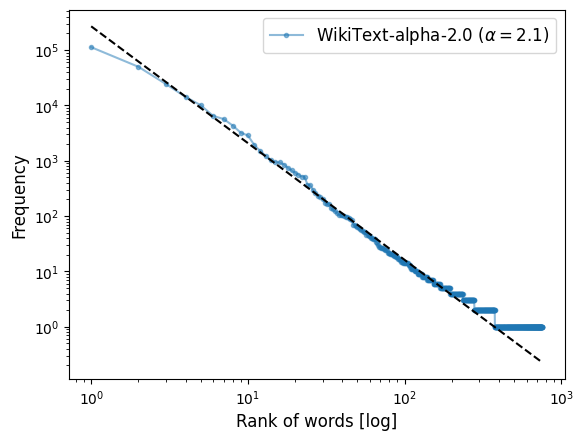

In [12]:
import matplotlib.pylab as plt

def plot_word_counts(word_counts, ax, label="", bulk_ratio=None, start_point=1, show_slope=True):
    eigenvalues = word_counts
    indices = np.arange(1, len(eigenvalues) + 1)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]

    start_index = max(start_point, 1)  # start_pointが1未満の場合を防ぐためにmaxを使用
    bulk = int(len(eigenvalues) * bulk_ratio) if bulk_ratio is not None else len(eigenvalues)
    
    # 指定された範囲のインデックスと固有値に基づいて傾きを計算
    slope, intercept = np.polyfit(np.log(indices[start_index-1:bulk]), np.log(sorted_eigenvalues[start_index-1:bulk]), 1)

    # 元のプロット
    ax.loglog(indices, sorted_eigenvalues, '.-', label=fr"{label} ($\alpha=${-slope:.2})", alpha=0.5)
    if show_slope:
        # 補助線をグラフ全体に延長してプロット
        ax.loglog(indices, np.exp(intercept) * indices ** slope, 'k--')


    print(f"Slope coefficient for {label}: {slope}")


fig, ax = plt.subplots()
plot_word_counts(sorted_word_counts, ax, label="WikiText-alpha-2.0", start_point=1, bulk_ratio=0.08)

ax.set_xlabel("Rank of words [log]", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.legend(prop={'size': 12})
plt.show()
